In [1]:
import numpy as np
import pandas as pd
import librosa

import os
import time
import re
from tqdm import tqdm
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
import IPython.display
import librosa.display

# Use GPU
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12459214076560219228
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7701992017342184686
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6611304431129888120
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2060293114877673696
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
def InceptionBlock(X_input, base_name):
    """
    Implementation of the Inception-A block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # Branch 1
    branch1 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same', name=base_name+'ia_branch_1_1')(X_input)
    branch1 = conv2d_bn(branch1, filters=96, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name=base_name+'ia_branch_1_2')
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters=96, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name=base_name+'ia_branch_2_1')
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name=base_name+'ia_branch_3_1')
    branch3 = conv2d_bn(branch3, filters=96, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name=base_name+'ia_branch_3_2')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 64, kernel_size = (1, 1), strides = (1, 1), padding = 'same', activation='relu', name = base_name + 'ia_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 96, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation='relu', name = base_name + 'ia_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 96, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation='relu', name = base_name + 'ia_branch_4_3')
    
    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.concat(values = [branch1, branch2, branch3, branch4], axis = 3, name='ia_concat')
    
    ### END CODE HERE ###
    
    return X

In [5]:
def DevNet(input_shape):
    
    X_input = tf.keras.Input(input_shape)
    
    # First branch with basic 3x3 kernel
    model = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', name='b1_conv0')(X_input)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    # Second branch with two stacked 3x3 kernel should equal to a single 9x9 from the original input
    branch_2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', name='b2_conv0')(X_input)
    branch_2 = tf.keras.layers.BatchNormalization(axis=3)(branch_2)
    branch_2 = tf.keras.layers.Activation('relu')(branch_2)
    branch_2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', name='b2_conv1')(branch_2)
    branch_2 = tf.keras.layers.BatchNormalization(axis=3)(branch_2)
    branch_2 = tf.keras.layers.Activation('relu')(branch_2)

    
    # Third branch with stacked dilated kernel
    branch_3 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), dilation_rate=(2, 2), padding='same', name='b3_conv0')(X_input)
    branch_3 = tf.keras.layers.BatchNormalization(axis=3)(branch_3)
    branch_3 = tf.keras.layers.Activation('relu')(branch_3)

    # Fifth branch with stacked dilated kernel
    branch_4 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), dilation_rate=(4, 4), padding='same', name='b5_conv0')(X_input)
    branch_4 = tf.keras.layers.BatchNormalization(axis=3)(branch_4)
    branch_4 = tf.keras.layers.Activation('relu')(branch_4)
    
    sdc = tf.concat(values=[branch_3, branch_4], axis=3, name='stacked_dilated_conv')
    sdc = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', name='sdc_conv')(sdc)
    
    #branch_3 = tf.keras.layers.ZeroPadding2D(padding=(9, 7))(branch_3)
    
    #branch_4 = tf.keras.layers.Conv2D(32, kernel_size=(9, 9), strides=(6, 5), padding='same', name='b4_conv0')(X_input)
    #branch_4 = tf.keras.layers.BatchNormalization(axis=3)(branch_4)
    #branch_4 = tf.keras.layers.Activation('relu')(branch_4)
    #branch_4 = tf.keras.layers.ZeroPadding2D(padding=(11, 9))(branch_4)
    
    
    '''
    model = tf.keras.layers.MaxPool2D(pool_size=(4, 3), strides=(1, 3), padding='same')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Second convolution block
    model = tf.keras.layers.Conv2D(80, kernel_size=(1, 3), strides=1, padding='same', name='conv1')(model)
    model = tf.keras.layers.Activation('relu')(model)
    model = tf.keras.layers.MaxPool2D(pool_size=(1, 3), strides=(1, 3), padding='same')(model)
    
    # Flatten
    model = tf.keras.layers.Flatten()(model)
    
    # First fully-connected block
    model = tf.keras.layers.Dense(5000, activation='relu', name='fc0')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Second fully-connected block
    model = tf.keras.layers.Dense(5000, activation='relu', name='fc1')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Output layer
    model = tf.keras.layers.Dense(50, activation='softmax', name='out')(model)
    '''
    
    # Contanetare all the parallel branches
    X = tf.concat(values=[model, branch_2, sdc], axis=3, name='test')
    

    ##### MAIN PATH ##### 
    # First component of main path (3 lines)
    main_path = tf.keras.layers.Conv2D(128, kernel_size=1, strides=2, padding='valid', kernel_initializer='glorot_uniform', name='main_path_' + '1st')(X)
    main_path = tf.keras.layers.BatchNormalization(axis=3)(main_path)
    main_path = tf.keras.layers.Activation('relu')(main_path)
    
    # Second component of main path (3 lines)
    main_path = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_uniform', name='main_path_' + '2nd')(main_path)
    main_path = tf.keras.layers.BatchNormalization(axis=3)(main_path)
    main_path = tf.keras.layers.Activation('relu')(main_path)

    # Third component of main path (2 lines)
    main_path = tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', kernel_initializer='glorot_uniform', name='main_path_' + '3rd')(main_path)
    main_path = tf.keras.layers.BatchNormalization(axis=3)(main_path)

    ##### SHORTCUT PATH #### (2 lines)
    X_shortcut = tf.keras.layers.Conv2D(256, kernel_size=1, strides=2, padding='valid', kernel_initializer='glorot_uniform', name='shortcut')(X)
    X_shortcut = tf.keras.layers.BatchNormalization(axis=3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X_final = tf.keras.layers.Add()([X_shortcut, main_path])
    X_final = tf.keras.layers.BatchNormalization(axis=3)(X_final)
    X_final = tf.keras.layers.Activation('relu')(X_final)
    
    # Flatten and fully connect the features
    model = tf.keras.layers.Flatten()(X_final)
    model = tf.keras.layers.Dense(1000, activation='relu', name='fc0')(model)
    
    # Create model
    model = tf.keras.Model(inputs=X_input, outputs=model, name='DevNet')
    
    return model

In [6]:
test = DevNet([60, 41, 2])

print(test.summary())

Model: "DevNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 41, 2)]  0                                            
__________________________________________________________________________________________________
b2_conv0 (Conv2D)               (None, 60, 41, 32)   608         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 60, 41, 32)   128         b2_conv0[0][0]                   
__________________________________________________________________________________________________
b3_conv0 (Conv2D)               (None, 60, 41, 32)   1632        input_2[0][0]                    
_____________________________________________________________________________________________

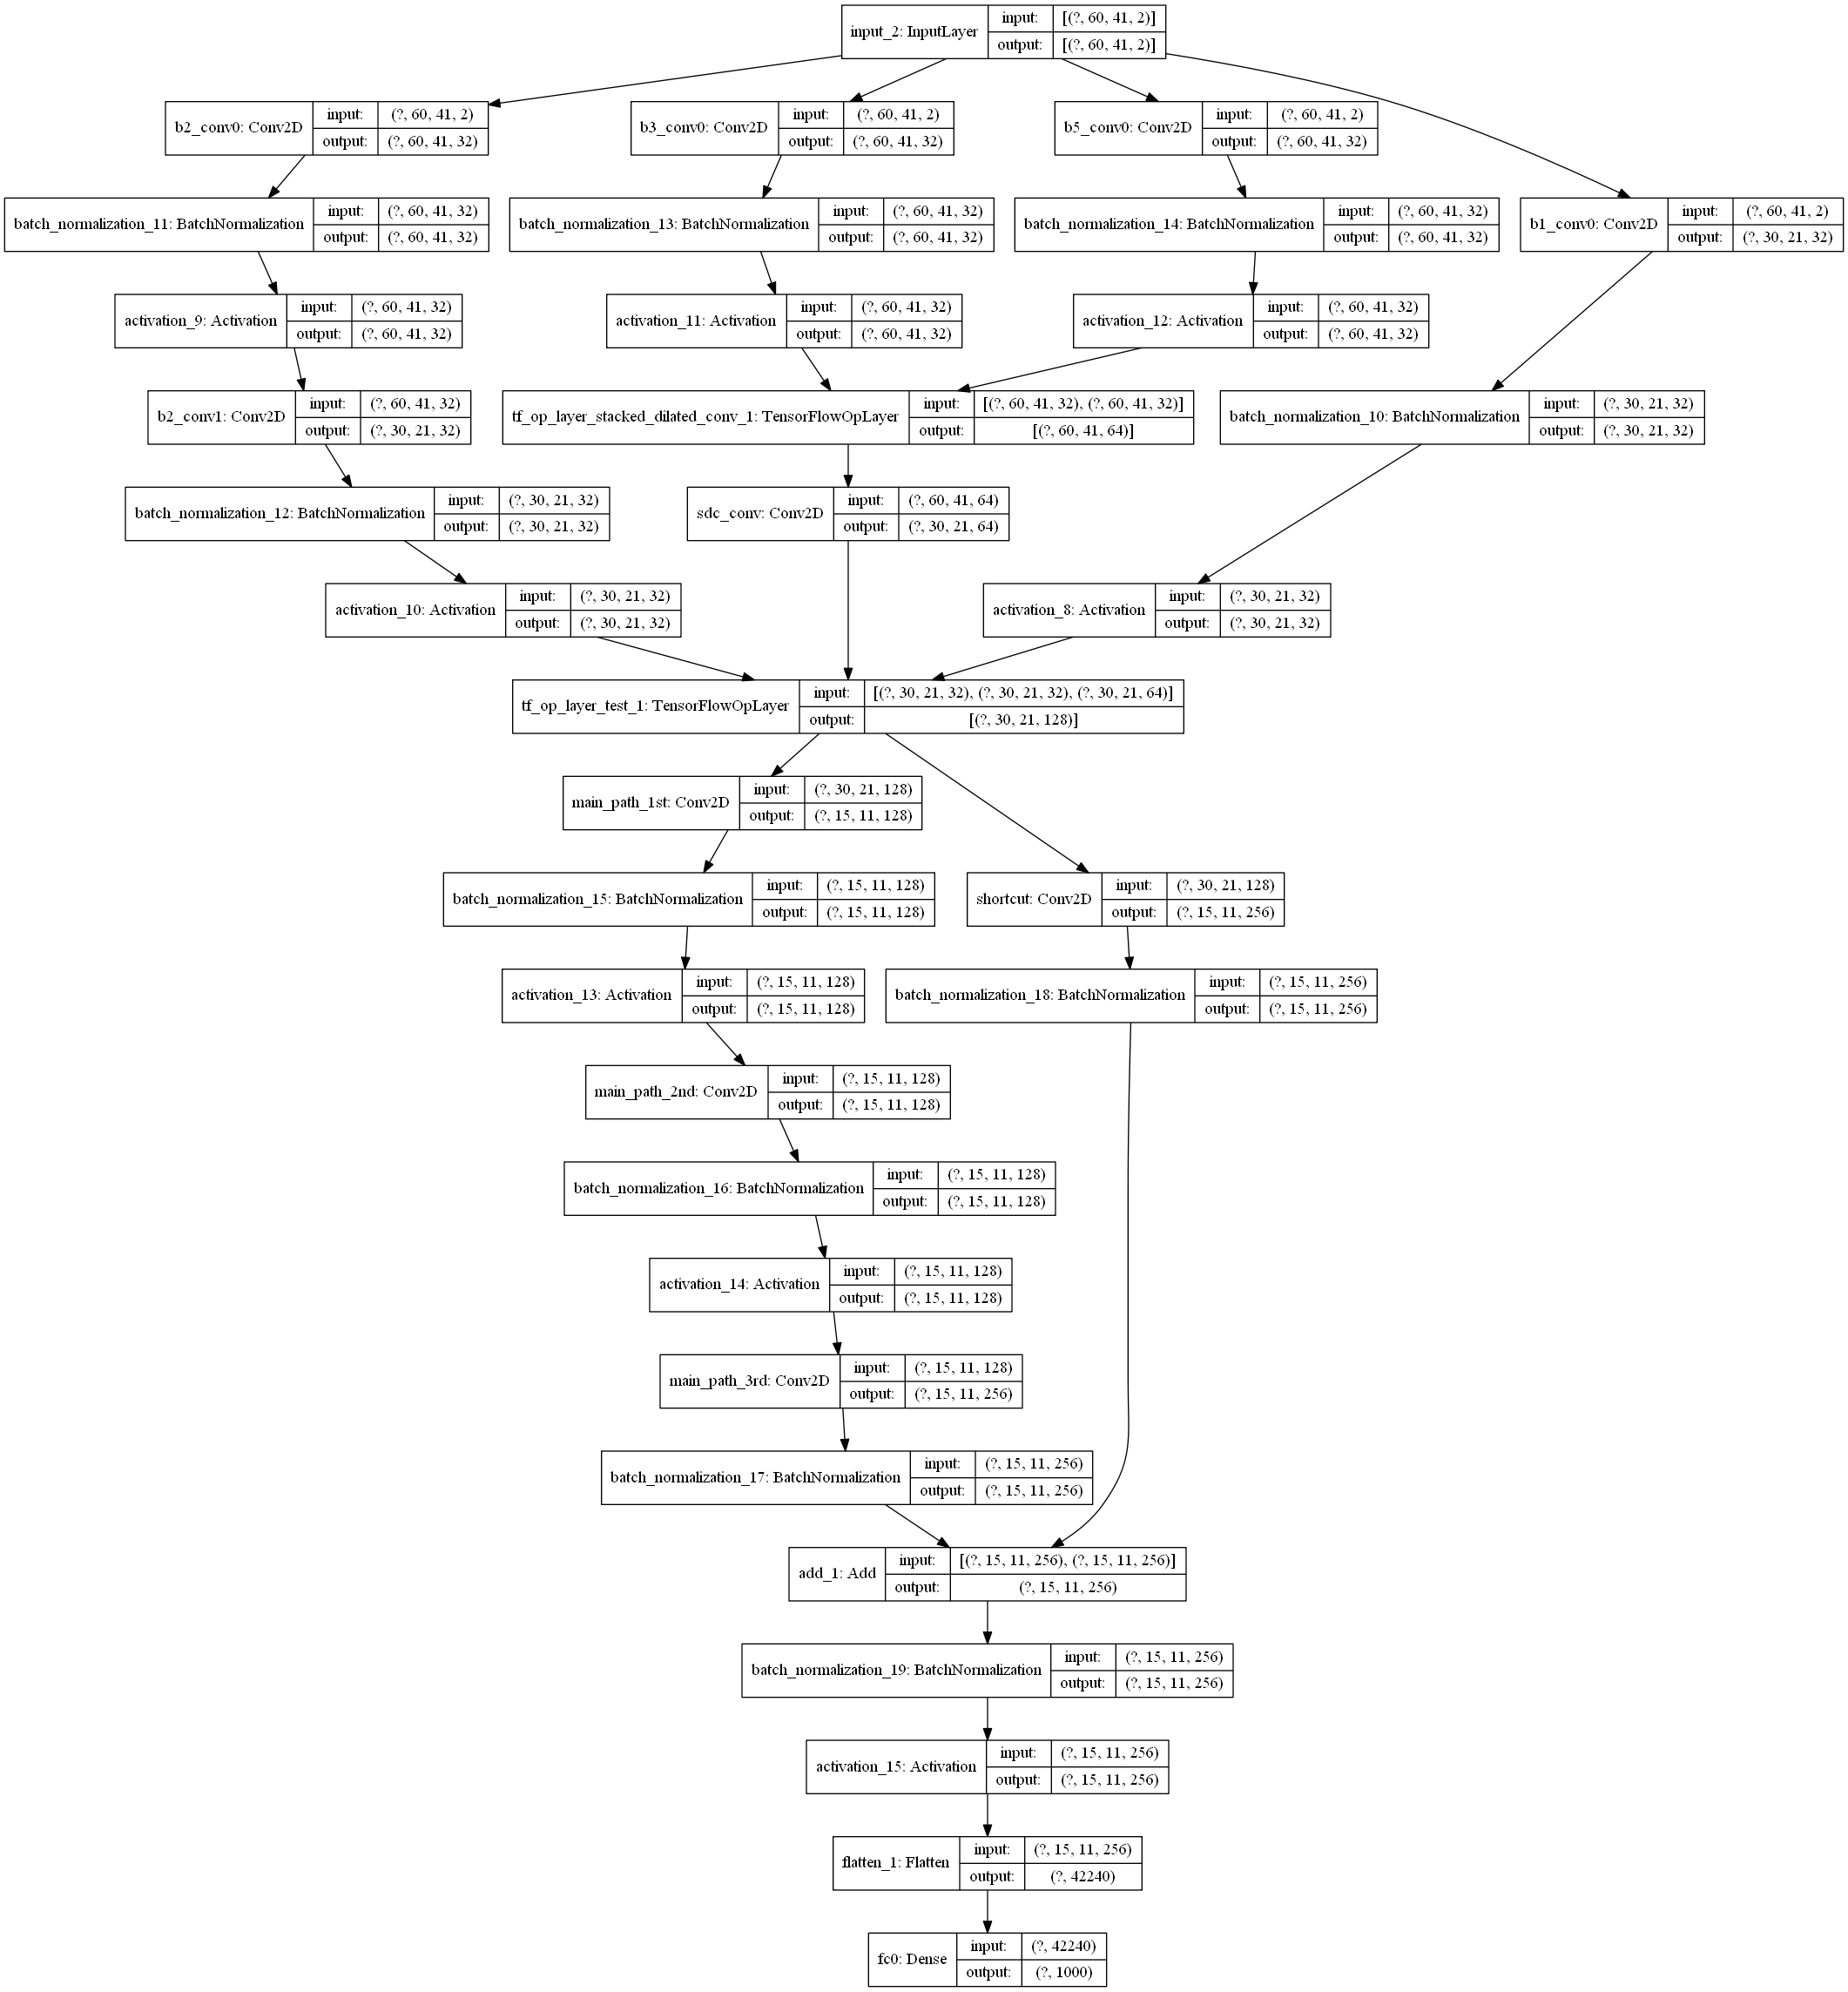

In [7]:
plot_model(test, show_shapes=True, show_layer_names=True)

In [8]:
def ESC50Classifier(input_shape=1000):
    
    X_input = tf.keras.Input(input_shape)
    
    # Feature reduction
    model = tf.keras.layers.Dense(500, activation='relu', name='fc1')(X_input)
    model = tf.keras.layers.Dropout(0.4)(model)
    
    # Output classifier layer
    model = tf.keras.layers.Dense(50, activation='softmax', name='out')(model)
    
    # Create model
    model = tf.keras.Model(inputs=X_input, outputs=model, name='ESC50_Classifier')
    
    return model

In [9]:
def MultiFeatureNet(back_bone, classifier):
    
    model = tf.keras.Model(inputs=back_bone.input, outputs=classifier(back_bone.output), name='Merged')
    
    return model

In [10]:
test_1 = DevNet([60, 41, 2])
test_2 = ESC50Classifier([1000])

Merged = MultiFeatureNet( test_1, test_2)

In [11]:
Merged.summary()

Model: "Merged"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60, 41, 2)]  0                                            
__________________________________________________________________________________________________
b2_conv0 (Conv2D)               (None, 60, 41, 32)   608         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 60, 41, 32)   128         b2_conv0[0][0]                   
__________________________________________________________________________________________________
b3_conv0 (Conv2D)               (None, 60, 41, 32)   1632        input_3[0][0]                    
_____________________________________________________________________________________________

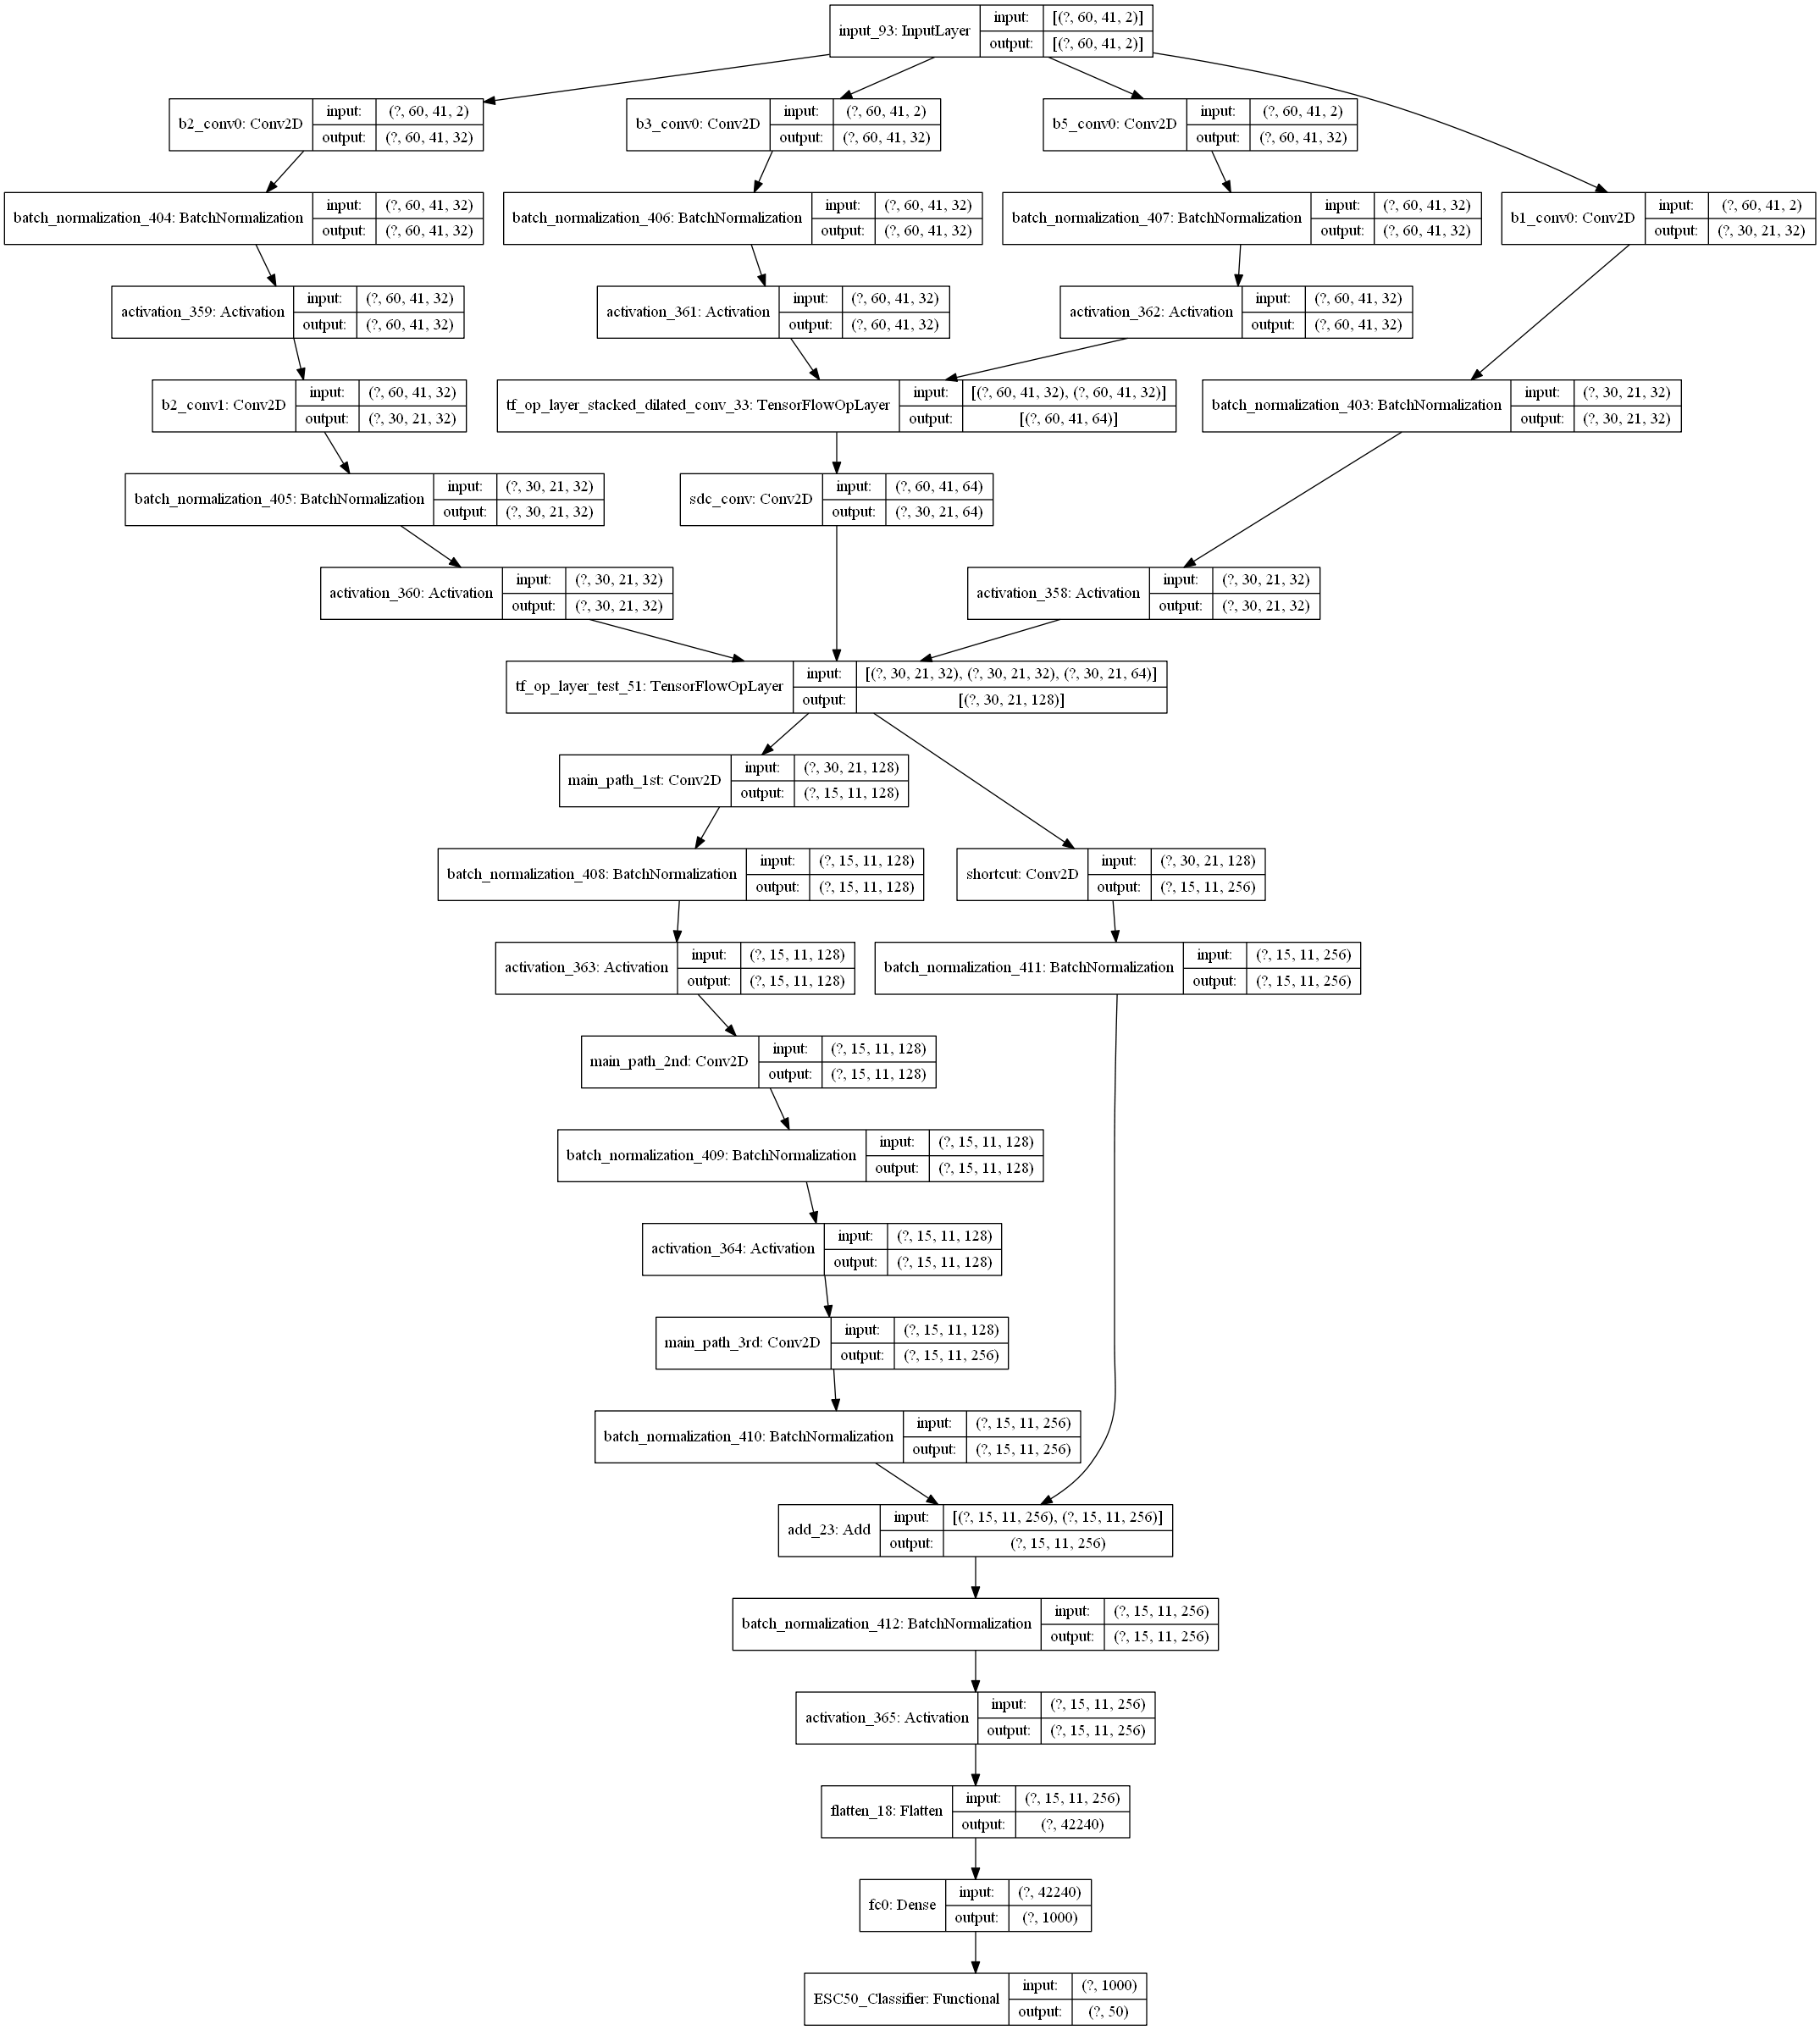

In [216]:
plot_model(Merged, show_shapes=True, show_layer_names=True)